In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from scipy import optimize
warnings.filterwarnings("ignore")

In [2]:
#import OIS discount factor data
df_ois = pd.read_excel('IR Data.xlsx', sheet_name='OIS').iloc[:,0:3]
df_irs = pd.read_excel('IR Data.xlsx', sheet_name='IRS').iloc[:,0:3]

In [3]:
#change the Tenor Column to numbers
def tenor_to_year(x):
    if x[-1] == "m":
        return float(x[:-1])/12
    elif x[-1] == "y":
        return float(x[:-1])

df_ois['Tenor'] = df_ois['Tenor'].apply(tenor_to_year)
df_irs['Tenor'] = df_irs['Tenor'].apply(tenor_to_year)

In [4]:
df_ois

,Tenor,Product,Rate
0,0.5,OIS,0.00250
1,1.0,OIS,0.00300
2,2.0,OIS,0.00325
3,3.0,OIS,0.00335
4,4.0,OIS,0.00350
5,5.0,OIS,0.00360
6,7.0,OIS,0.00400
7,10.0,OIS,0.00450
8,15.0,OIS,0.00500
9,20.0,OIS,0.00525


### A. OIS Discount Curve

In [5]:
def discount_ois(prev, forward, years):
    if years < 2:
        n = 0.5
    else:
        n = 1
    return prev * (1 / (1+forward/360)**(360*n))

def ois_forward(forward, years):
    if years < 2:
        n = 0.5
    else:
        n = 1
    return (1+forward/360)**(360*n) - 1

def ois_root_search(total, Prev, fixed_rate, prev_float_sum, f, N):
    return (total + discount_ois(Prev, f, N))* fixed_rate - prev_float_sum - discount_ois(Prev, f, N) * ois_forward(f, N)

def ois_root_search_without_ois(years, total_df, prev, fixed_rate, prev_float_sum, f, N):
    lhs = total_df
    rhs = prev_float_sum
    temp_prev = prev
    
    for i in range (1, years+1):
        temp_df = discount_ois(temp_prev, f, 2)
        lhs += temp_df
        rhs += temp_df * ois_forward(f, 2)
        temp_prev = temp_df
    return lhs * fixed_rate - rhs

In [6]:
ois_rates_compounded = [0]
ois_discount_factors = []

count = 2 

prev_float_sum_temp = 0.0
prev_disc_factor_temp = 1.0

# Calculate f0
f0 = optimize.brentq(lambda x :discount_ois(prev_disc_factor_temp, x, 0.5) * 0.5 * 0.0025 
                     - discount_ois(prev_disc_factor_temp, x, 0.5) * ((1 + x/360)**180 -1), 1e-12, 1)

prev_disc_factor_temp *= (1/(1+f0/360)**180)

# Calculate f1
f1 = optimize.brentq(lambda x :discount_ois(prev_disc_factor_temp, x, 1) * 0.003 - discount_ois(prev_disc_factor_temp, x, 0.5) * 
                     ((1 + x/360)**180 *(1+f0/360)**180 -1), 1e-12, 1)

prev_float_sum_temp += discount_ois(prev_disc_factor_temp, f1, 1) * ((1 + f1/360)**180 * (1+f0/360)**180 - 1)
prev_disc_factor_temp *= (1/(1+f1/360)**180)
ois_discount_factors.append(prev_disc_factor_temp)
ois_rates_compounded.append(f1)

# Calculating OIS DF for years 2 to 30
i = 2
while i < 31:
    year_temp = df_ois['Tenor'][count]
    
    while ( i > year_temp):
        count += 1
        year_temp = df_ois['Tenor'][count]
    
    fixed_rate_temp = df_ois['Rate'][count]
    
    if ( i != year_temp):
        
        num_of_years  = int(year_temp - i + 1)
        
        tempF = optimize.brentq(lambda x :ois_root_search_without_ois(num_of_years, sum(ois_discount_factors),
                                    prev_disc_factor_temp, fixed_rate_temp, prev_float_sum_temp, x, i), 1e-12, 1)
        
        for j in range (num_of_years):
            prev_float_sum_temp += discount_ois(prev_disc_factor_temp, tempF, 2) * ois_forward(tempF, 2)
            prev_disc_factor_temp *= (1/(1+tempF/360)**360)
            ois_discount_factors.append(prev_disc_factor_temp)
            ois_rates_compounded.append(tempF)
        i = year_temp + 1
            
    else :
        tempF = optimize.brentq(lambda x :ois_root_search(sum(ois_discount_factors), prev_disc_factor_temp,
                                    fixed_rate_temp, prev_float_sum_temp, x, i), 1e-12, 1)
        prev_float_sum_temp += discount_ois(prev_disc_factor_temp, tempF, i) * ois_forward(tempF, i)
        prev_disc_factor_temp *= (1/(1+tempF/360)**360)
        ois_discount_factors.append(prev_disc_factor_temp)
        ois_rates_compounded.append(tempF)
        i += 1

In [7]:
interpolated_ois_df = [1,(1/(1+f0/360)**180)]
for i in range(len(ois_discount_factors)):
    if i == len(ois_discount_factors) - 1:
        interpolated_ois_df.append(ois_discount_factors[-1])
    else:
        a = ois_discount_factors[i]
        b = ois_discount_factors[i+1]
        c = (a + b) / 2
        interpolated_ois_df.append(a)
        interpolated_ois_df.append(c)

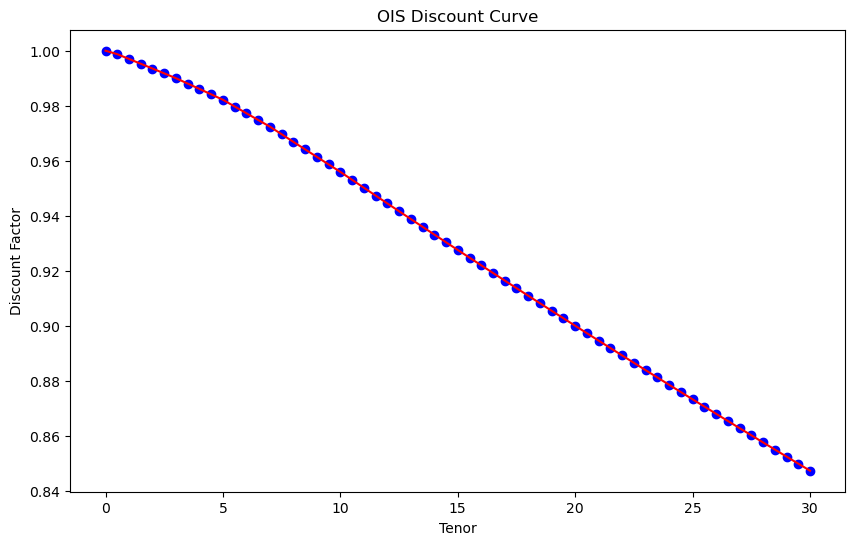

In [8]:
# plot the result
plt.figure(figsize = (10, 6))
plt.plot(np.arange(0, 30.5, 0.5), interpolated_ois_df, color="r")
plt.scatter(np.arange(0, 30.5, 0.5), interpolated_ois_df, color="b")
plt.xlabel('Tenor')
plt.ylabel('Discount Factor')
plt.title('OIS Discount Curve')
plt.show()

In [9]:
discount_factors = pd.DataFrame()
discount_factors['Tenor'] = np.arange(0,30.5,0.5)
discount_factors['OISDiscountFactors'] = interpolated_ois_df
discount_factors

,Tenor,OISDiscountFactors
0,0.0,1.000000
1,0.5,0.998752
2,1.0,0.997009
3,1.5,0.995270
4,2.0,0.993531
...,...,...
56,28.0,0.857703
57,28.5,0.855126
58,29.0,0.852548
59,29.5,0.849986


### B. LIBOR Discount Curve

In [10]:
# functions to calculate bootstrap LIBOR discount
def libor_root_search(sum_of_ois, libor_fwd, fixed_rate, prev_discount, discount, year_count):
    lhs = 0.5 * sum(sum_of_ois[1:int(year_count)*2+1]) * fixed_rate
    rhs = 0
    limit = len(libor_fwd) - 2
    temp_diff = (prev_discount - discount) / 2
    temp_prev = prev_discount
    for j in range(int(year_count) * 2):
        if j <= limit:
            rhs += 0.5 * sum_of_ois[j+1] * libor_fwd[j+1]                            
        else:
            rhs += (temp_prev-(temp_prev - temp_diff))/(temp_prev - temp_diff) * sum_of_ois[j+1]
            temp_prev = prev_discount-temp_diff
    
    return lhs - rhs

def libor_root_search_without_irs(sum_of_ois, libor_fwd, count_6m, fixed_rate, prev_discount, discount, year_count):
    lhs = 0.5 * sum(sum_of_ois[1:int(year_count)*2+1]) * fixed_rate
    rhs = 0
    temp_diff = (prev_discount - discount) / count_6m
    temp_prev = prev_discount
    # print(PrevDiscount)
    limit = len(libor_fwd)-2
    for j in range(int(year_count) * 2):
        if j <= limit:
            rhs += 0.5 * sum_of_ois[j+1] * libor_fwd[j+1] 
        else:
            test = 2 * sum_of_ois[j+1] * (temp_prev-(temp_prev - temp_diff))/(temp_prev - temp_diff) 
            rhs += 0.5 * test
            temp_prev = temp_prev - temp_diff
                  
    return lhs - rhs

def calculate_fwd_libor(prev_discount, discount):
    temp = 2 * (prev_discount - discount) / discount
    return temp

In [11]:
libor_discount_factors = [1]
libor_forward_rates = [0,0.025]

# calculate [0,6m] discount factor
libor_6m = 1 / (1 + (0.5 * df_irs['Rate'][0]))
libor_discount_factors.append(libor_6m)

# calculate [0,1y] discount factor
libor_1y = optimize.brentq(lambda x : 0.5 *(sum(interpolated_ois_df[1:3])) * df_irs['Rate'][1] - 
        0.5 * df_irs['Rate'][0] * interpolated_ois_df[1] - 0.5 * (2*(libor_6m-x)/x) * interpolated_ois_df[2], 1e-12, 1)

libor_discount_factors.append(libor_1y)

# appending LIBOR forward for [6m,1y]
libor_forward_rates.append(2*(libor_6m-libor_1y)/libor_1y)

count = 2 
prev_float_sum_temp = 0.0
prev_disc_factor_temp = 1.0

i = 2
while i < 31:
    year_temp = df_irs['Tenor'][count]

    while ( i > year_temp):
        count += 1
        year_temp = df_irs['Tenor'][count]
        
    fixed_rate_temp = df_irs['Rate'][count]
    previous_discount = libor_discount_factors[-1]
    temp_diff = 0
    
    if ( i != year_temp):
        count_6m  = int((year_temp - i +1) * 2) 
        temp_discount = optimize.brentq(lambda x :libor_root_search_without_irs(interpolated_ois_df, libor_forward_rates, 
                                    count_6m, fixed_rate_temp, previous_discount, x, year_temp), 1e-12, 1)
        
        temp_diff = (previous_discount - temp_discount) / count_6m
        for j in range (count_6m):
            # calculating LIBOR discount factor and append 
            previous_discount = libor_discount_factors[-1]
            temp_discount = previous_discount - temp_diff
            libor_discount_factors.append(temp_discount)
            
            # appending LIBOR forward rates
            tempLIBORFwd = calculate_fwd_libor(previous_discount, temp_discount)
            libor_forward_rates.append(tempLIBORFwd)
        
        # let loop continue from year_temp
        i = year_temp + 1   
        
    else :
        # optimising to find LIBOR discount rate
        temp_discount = optimize.brentq(lambda x :libor_root_search(interpolated_ois_df, libor_forward_rates,
                                            fixed_rate_temp, previous_discount, x, year_temp), 1e-12, 1)
        
        tempDiscount_05 = (previous_discount + temp_discount) / 2
        
        # appending discount factors to list
        libor_discount_factors.append(tempDiscount_05)
        libor_discount_factors.append(temp_discount)
        
        # appending LIBOR forward rates
        libor_forward_rates.append(calculate_fwd_libor(previous_discount, tempDiscount_05))
        libor_forward_rates.append(calculate_fwd_libor(tempDiscount_05, temp_discount))

        i += 1

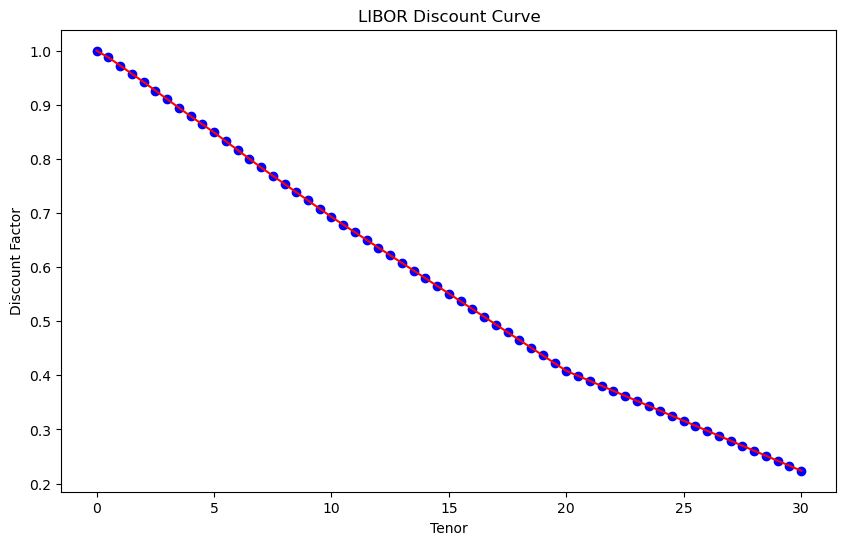

In [12]:
plt.figure(figsize = (10, 6))
plt.plot(np.arange(0, 30.5, 0.5), libor_discount_factors, color = "r")
plt.scatter(np.arange(0, 30.5, 0.5), libor_discount_factors, color = "b")
plt.xlabel('Tenor')
plt.ylabel('Discount Factor')
plt.title('LIBOR Discount Curve')
plt.show()

In [13]:
discount_factors['LIBORDiscountFactors'] = libor_discount_factors
discount_factors

,Tenor,OISDiscountFactors,LIBORDiscountFactors
0,0.0,1.000000,1.000000
1,0.5,0.998752,0.987654
2,1.0,0.997009,0.972577
3,1.5,0.995270,0.957378
4,2.0,0.993531,0.942179
...,...,...,...
56,28.0,0.857703,0.260568
57,28.5,0.855126,0.251340
58,29.0,0.852548,0.242112
59,29.5,0.849986,0.232884


In [14]:
discount_factors.to_csv('Discount Factors.csv')

### C. Forward Swap Rates

In [15]:
# function to calculate forward swap rates
def cal_forward_swap_rates(start, tenor, ois_list, libor_fwd_list):
    end = start + tenor
    numerator = 0
    denominator = 0.5 * sum(ois_list[start*2+1:end*2+1])
    counter = start * 2 + 1
    for i in range (tenor*2):
        numerator += ois_list[counter] * libor_fwd_list[counter] * 0.5
        counter += 1
    return numerator / denominator

In [16]:
forward_swap_rate = pd.DataFrame(columns=["Start", "Tenor", "Forward Swap"])

# respective OIS discount factors and LIBOR forward rate list
ois_list = interpolated_ois_df
libor_fwd_list = libor_forward_rates

tenor = [1, 2, 3, 5, 10]
start = [1, 5, 10]
for i in start:
    for j in tenor:
        temp_swap_rate  = cal_forward_swap_rates(i, j, ois_list, libor_fwd_list)
        new_row = {'Start':i, 'Tenor':j, 'Forward Swap':temp_swap_rate }
        # append row to the dataframe
        forward_swap_rate = pd.concat([forward_swap_rate, pd.DataFrame([new_row])], ignore_index=True)


In [17]:
forward_swap_rate["Start"] = forward_swap_rate["Start"].apply(lambda x: int(x))
forward_swap_rate["Tenor"] = forward_swap_rate["Tenor"].apply(lambda x: int(x))

In [18]:
pvbps = []
for i in range(len(forward_swap_rate.Start)):
    a = forward_swap_rate["Start"][i]*2
    b = forward_swap_rate["Tenor"][i]*2
    pvbp = sum(interpolated_ois_df[a:a+b])/2
    pvbps.append(pvbp)
    

In [19]:
forward_swap_rate["PVBP"] = pvbps
forward_swap_rate.to_csv('Forward Swap.csv')